# Lab 09: MLB Swing Probability Modeling

---
author: Jakub Szumny
date: December 4, 2024
embed-resources: true
---

## Introduction

Baseball can be pretty much split up into to sides: a pitcher, who's job is to prevent batters from hitting to reach a base; and a batter is to reach a base by hitting or getting a walk. The batter is constantly trying to anticipate the pitch and the pitcher is constantly trying to decieve the batter. Pitchers tend to want to make betters swing at pitches which have a low probability of hit success, and pitchers want batters to not swing to get a strike. As a data scientist working for a Major League Baseball team, my goal is to create a well calibrated probability model which estimates the probability of inducing a batter to swing given the characteristics of a pitch thrown, along with the game situation. I will be using a classification model for this problem.

## Methods

In [98]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
import sklearn

# machine learning
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

### Data

In [99]:
# load data
pitches_train = pd.read_csv(
    "https://cs307.org/lab-09/data/pitches-train.csv",
)
pitches_test = pd.read_csv(
    "https://cs307.org/lab-09/data/pitches-test.csv",
)
pitches_train

,pitch_name,release_extension,release_pos_x,release_pos_y,release_pos_z,release_speed,release_spin_rate,spin_axis,plate_x,plate_z,...,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,stand,sz_top,sz_bot,swing
0,Cutter,6.6,-2.76,53.86,5.81,92.6,2376.0,195.0,-0.09,2.79,...,3,1,0,0,0,1,L,3.15,1.52,1
1,Changeup,6.8,-2.87,53.74,5.66,86.3,1511.0,226.0,-1.47,1.84,...,2,1,0,0,0,1,L,3.13,1.56,0
2,Changeup,6.7,-2.83,53.82,5.68,87.9,1570.0,224.0,-1.52,2.38,...,1,1,0,0,0,1,L,3.12,1.51,0
3,Knuckle Curve,6.7,-2.70,53.78,5.78,82.4,2398.0,32.0,0.20,1.04,...,1,0,0,0,0,1,L,3.15,1.52,1
4,Cutter,6.7,-2.64,53.83,5.81,91.0,2427.0,189.0,0.89,1.65,...,0,0,0,0,0,1,L,3.12,1.51,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2648,4-Seam Fastball,6.8,-2.64,53.75,5.99,93.4,2411.0,206.0,0.59,2.91,...,0,0,0,0,0,1,L,3.50,1.81,0
2649,Slider,6.3,-2.91,54.19,5.86,87.3,2541.0,113.0,1.38,1.73,...,1,2,0,0,0,0,R,3.19,1.48,1
2650,Knuckle Curve,6.4,-2.91,54.13,5.87,84.7,2539.0,35.0,0.81,0.11,...,1,1,0,0,0,0,R,3.19,1.48,1
2651,4-Seam Fastball,6.4,-2.67,54.13,6.04,94.3,2531.0,201.0,1.05,1.79,...,0,1,0,0,0,0,R,3.03,1.48,0


The data has been provided for me, and is from Statcast, but I will only be focusing on a specific pitcher, Zac Gallen. The data is split based on time during the 2023 MLB season, instead of randomly splitting the data, to try and predict into the future.

The dataset includes:

## Response

- **swing** `[int64]`:  
  Whether or not the batter swung (1) or took (0).

## Features

### Fully Pitcher Controlled

- **pitch_name** `[object]`:  
  The name of the pitch type to be thrown.

### Mostly Pitcher Controlled

- **release_extension** `[float64]`:  
  Release extension of the pitch in feet as tracked by Statcast.
- **release_pos_x** `[float64]`:  
  Horizontal release position of the ball measured in feet from the catcher’s perspective.
- **release_pos_y** `[float64]`:  
  Release position of the pitch measured in feet from the catcher’s perspective.
- **release_pos_z** `[float64]`:  
  Vertical release position of the ball measured in feet from the catcher’s perspective.

### Somewhat Pitcher Controlled

- **release_speed** `[float64]`:  
  Velocity of the pitch thrown.
- **release_spin_rate** `[float64]`:  
  Spin rate of the pitch as tracked by Statcast.
- **spin_axis** `[float64]`:  
  The spin axis in the 2D X-Z plane, measured in degrees from 0 to 360, where 180 represents a pure backspin fastball and 0 degrees represents a pure topspin (12-6) curveball.
- **plate_x** `[float64]`:  
  Horizontal position of the ball when it crosses home plate from the catcher’s perspective.
- **plate_z** `[float64]`:  
  Vertical position of the ball when it crosses home plate from the catcher’s perspective.

### Downstream Pitcher Controlled

- **pfx_x** `[float64]`:  
  Horizontal movement in feet from the catcher’s perspective.
- **pfx_z** `[float64]`:  
  Vertical movement in feet from the catcher’s perspective.

### Situational Information

- **balls** `[int64]`:  
  Pre-pitch number of balls in the count.
- **strikes** `[int64]`:  
  Pre-pitch number of strikes in the count.
- **on_3b** `[int64]`:  
  Pre-pitch MLB Player ID of the runner on 3B.
- **on_2b** `[int64]`:  
  Pre-pitch MLB Player ID of the runner on 2B.
- **on_1b** `[int64]`:  
  Pre-pitch MLB Player ID of the runner on 1B.
- **outs_when_up** `[int64]`:  
  Pre-pitch number of outs.

### Fixed Batter Information

- **stand** `[object]`:  
  Side of the plate the batter is standing on.
- **sz_top** `[float64]`:  
  Top of the batter’s strike zone, set by the operator when the ball is halfway to the plate.
- **sz_bot** `[float64]`:  
  Bottom of the batter’s strike zone, set by the operator when the ball is halfway to the plate.


In [100]:
# summary statistics
print("Num Samples:", len(pitches_train))
print("Num Features:", pitches_train.shape[1]-1)

Num Samples: 2653
Num Features: 21


In [101]:
print("All:", len(pitches_train[pitches_train["swing"] == 1]) / len(pitches_train))
print("4-Seam Fastball:", len(pitches_train[(pitches_train["pitch_name"] == "4-Seam Fastball") & (pitches_train["swing"] == 1)]) / len(pitches_train[pitches_train["pitch_name"] == "4-Seam Fastball"]))
print("Changeup:", len(pitches_train[(pitches_train["pitch_name"] == "Changeup") & (pitches_train["swing"] == 1)]) / len(pitches_train[pitches_train["pitch_name"] == "Changeup"]))
print("Cutter:", len(pitches_train[(pitches_train["pitch_name"] == "Cutter") & (pitches_train["swing"] == 1)]) / len(pitches_train[pitches_train["pitch_name"] == "Cutter"]))
print("Knuckle Curve:", len(pitches_train[(pitches_train["pitch_name"] == "Knuckle Curve") & (pitches_train["swing"] == 1)]) / len(pitches_train[pitches_train["pitch_name"] == "Knuckle Curve"]))
print("Slider:", len(pitches_train[(pitches_train["pitch_name"] == "Slider") & (pitches_train["swing"] == 1)]) / len(pitches_train[pitches_train["pitch_name"] == "Slider"]))

All: 0.47757255936675463
4-Seam Fastball: 0.4714506172839506
Changeup: 0.5363128491620112
Cutter: 0.453781512605042
Knuckle Curve: 0.4628751974723539
Slider: 0.4921875


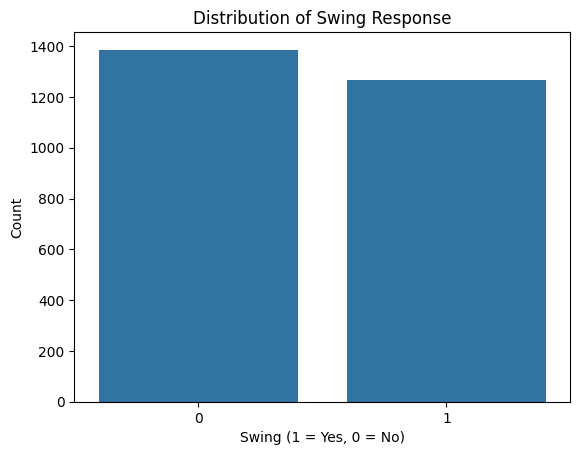

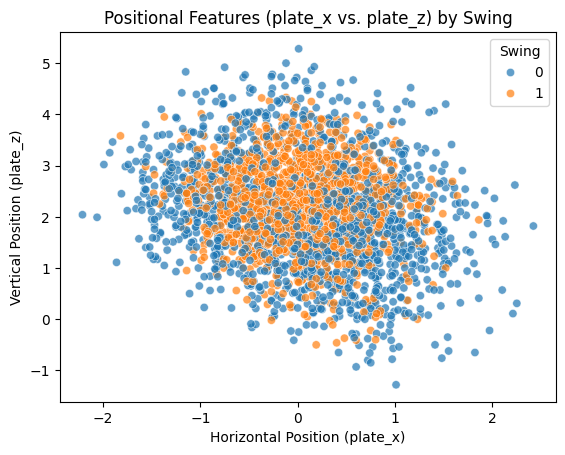

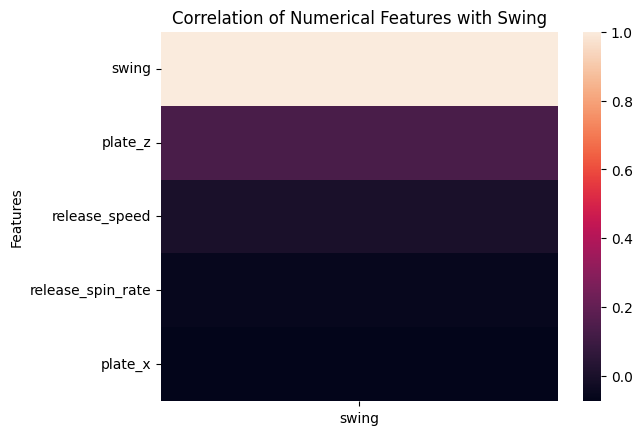

In [112]:
# visualizations
sns.countplot(x='swing', data=pitches_train)
plt.title('Distribution of Swing Response')
plt.xlabel('Swing (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

numerical_features = ['release_speed', 'release_spin_rate', 'plate_x', 'plate_z']

sns.scatterplot(data=pitches_train, x='plate_x', y='plate_z', hue='swing', alpha=0.7)
plt.title('Positional Features (plate_x vs. plate_z) by Swing')
plt.xlabel('Horizontal Position (plate_x)')
plt.ylabel('Vertical Position (plate_z)')
plt.legend(title='Swing')
plt.show()

correlation_data = pitches_train[numerical_features + ['swing']].corr()
sns.heatmap(correlation_data[['swing']].sort_values(by='swing', ascending=False))
plt.title('Correlation of Numerical Features with Swing')
plt.ylabel('Features')
plt.show()


Based off of the summary statistics, we can see that there is almost always about a 50% swing rate on each different type of pitch. This means that some other features definitely need to help along with the pitch type to make accurate predictions. Based off of the visualizations we can see that there are slightly more non swings than swings. Also based off of the positions on the plate, we can see that when the ball seems to be right in the perfect spot on the plate, it is almost always a swing, but when the ball is on the outer parts of the plate, it is usually a non-swing. We can also see that there is not much correlation with numerical features, other than plate_z.

### Models

In [113]:
# process data for ML
# create X and y for train data
X_train = pitches_train.drop(columns=["swing"])
y_train = pitches_train["swing"]

# create X and y for test data
X_test = pitches_test.drop(columns=["swing"])
y_test = pitches_test["swing"]

In [115]:
# train models
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier())

    ]
)

# define parameter grid
param_grid = {
    "classifier__n_estimators": [70, 75, 80],
    "classifier__max_depth": [None,2],
    "classifier__min_samples_split": [4,5],
    "classifier__min_samples_leaf": [2],
    "classifier__max_features": ['sqrt'],
    "classifier__class_weight": ["balanced"],
    }

# # setup grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="f1")

# run grid search with cross-validation
grid_search.fit(X_train, y_train)

# print best parameters found and best (cross-validated) score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation f1: {grid_search.best_score_}")

Best parameters: {'classifier__class_weight': 'balanced', 'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 75}
Best cross-validation f1: 0.6988476602792152


Here I used a pipeline and a GridSearch Cross Validation to find the best parameters for this model based on F1-Score, using a Random Forest Classifier model. I found that the best class weight was balanced, the best max depth is None, the best max features is sqrt, the best min samples leaf is 2, the best min samples split is 5, and the best number of trees is 75. Here I recieved a cross validation f1 score of .698, but now we have to do some more to find the ECE and MCE scores.

## Results

In [117]:
# report model metrics
from sklearn.calibration import calibration_curve
y_pred = grid_search.predict_proba(X_test)[:, 1]

prob_true, prob_pred = calibration_curve(y_test, y_pred, n_bins=10)
bin_counts = np.histogram(y_pred, bins=len(prob_true), range=(0, 1))[0]
bin_counts_normalized = bin_counts / len(y_test)

ece = np.sum(np.abs(prob_true - prob_pred) * bin_counts_normalized)
mce = np.max(np.abs(prob_true - prob_pred))

print("Test ECE:", ece)
print("Test MCE:", mce)

Test ECE: 0.06709552663140363
Test MCE: 0.12042662119300596


The model recieved a test ECE of .067, and a test MCE of .12. As the calibration error scores are rather small, it is a good sign as we want as little calibration error as possible for this model, as it shows it has a good ability to estimate the probability of a swing.

In [96]:
from joblib import dump
dump(grid_search, "swing-probability.joblib")

['swing-probability.joblib']

## Discussion

After receiving the model metrics, and seeing that there is a low calibration error when estimating swing probabilities, I can say that this is a rather good model at predicting the probabilities of a swing based on a lot of different features. The max error was .12 which is not great but the expected is rather low which is a good sign.

If I were to try and use this model as an MLB coach, the variables I would ask the pitcher to modify to induce a swing are the variables on the actual ball. We can see that when the ball ends up on the edge of box the batter tends to not swing, but when it is in the middle of the box, the batter will most likely swing. So in order to induce a swing, I believe the pitch must at first seem it is going smack dab in the middle, but then curve and end up on the edge or even out of the box. This way the batter will swing thinking it is in a good position, but will hopefully either miss or swing and get a strike. Basically any variable which induces movement in the ball, such as speed, rotation, ball spin, is what I would ask the pitcher to modify in order to induce a swing.

### Conclusion

To conclude, given the low ECE and MCE scores of the model, I would say this model definitely makes rather good estimations on the probability that a batter will swing or not, and that it is at a good start, but that it is not yet ready for use in the real world. I believe that the ECE and MCE scores could be lowered further, and that the model could be even more accurate and preciting the probability of swings, but it is just not perfect currently. There are no big risks of this model giving bad probabilities, except for moments in a big game where you need a strike out, and the model said that a particular way of throwing at this state of the game would most likely be a strike, but it ends up getting hit and losing the game. Overall, the model is off to a good start, but could definitely be further improved upon.